# Hipótesis de regresión

Se plantea que el gasto monetario de un cliente (Monetary) está influido por su comportamiento transaccional y temporal.
En particular, se espera que los clientes que realizan montos más atípicos respecto a su ubicación (AmountZScoreByLocation) tiendan a gastar más, mientras que quienes dejan pasar más tiempo entre una transacción y otra (TimeSinceLastTxn) reducen su nivel de gasto.
Asimismo, se considera que el momento en que operan (IsLateNight, IsWeekend) puede tener un efecto moderado sobre su gasto promedio.

El objetivo del análisis es evaluar y cuantificar estas relaciones mediante modelos de regresión, identificando qué variables explican mejor el gasto del cliente y cómo se comportan sus efectos dentro de los modelos.

En simples palabras Busca entender qué comportamientos hacen que una persona gaste más o menos dinero.

| Tipo             | Variable                   | Descripción                                                          | Relación esperada |
| ---------------- | -------------------------- | -------------------------------------------------------------------- | ----------------- |
| Dependiente   | **Monetary**               | Monto total gastado en el período.                                   | —                 |
| Independiente | **AmountZScoreByLocation** | Qué tan atípicos son los montos del cliente respecto a su ubicación. | Positiva          |
| Independiente | **TimeSinceLastTxn**       | Tiempo transcurrido desde la última transacción.                     | Negativa          |
| Independiente | **IsLateNight**            | Indica si la transacción fue durante la noche.                       | Moderada          |
| Independiente | **IsWeekend**              | Indica si la transacción fue en fin de semana.                       | Moderada          |


In [1]:
# Carga de contexto y librerias para el notebook :D
%load_ext kedro.ipython
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [2]:
df = catalog.load("Features_training_v2")   # lee el dataset del catálogo
list(df.columns)  

[10/28/25 17:03:02] INFO     Loading data from Features_training_v2 (ParquetDataset)...        ]8;id=34797;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=190762;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

['Monetary', 'TimeSinceLastTxn', 'IsLateNight', 'AmountZScoreByLocation', 'IsWeekend']

In [3]:
# =========================================================
# ⚙️ LASSO REGRESSION – PREDICCIÓN DE MONETARY
# =========================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================================================
# 1️⃣ Variables dependiente e independientes
# =========================================================
X = df[["AmountZScoreByLocation", "TimeSinceLastTxn", "IsLateNight", "IsWeekend"]]
y = df["Monetary"]

# =========================================================
# 2️⃣ División Train/Test
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================================================
# 3️⃣ Escalamiento
# =========================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================================================
# 4️⃣ Modelo Lasso + Cross Validation
# =========================================================
lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2 = cross_val_score(lasso, X_train_scaled, y_train, cv=cv, scoring="r2")
cv_rmse = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, cv=cv, scoring="neg_mean_squared_error"))

print("=== Cross Validation Results (5-Fold) ===")
print("R² promedio:", round(cv_r2.mean(), 4))
print("R² desviación:", round(cv_r2.std(), 4))
print("RMSE promedio:", round(cv_rmse.mean(), 2))

# =========================================================
# 5️⃣ Entrenamiento y evaluación en test
# =========================================================
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

results_lasso = {
    "model_name": "LassoRegression",
    "r2_mean_cv": round(cv_r2.mean(), 4),
    "r2_std_cv": round(cv_r2.std(), 4),
    "r2_test": round(r2, 4),
    "rmse": round(rmse, 2),
    "mae": round(mae, 2)
}

print("\n=== Resultados en Test ===")
print(results_lasso)

# =========================================================
# 6️⃣ Coeficientes
# =========================================================
coef_df_lasso = pd.DataFrame({
    "Variable": X.columns,
    "Coeficiente": lasso.coef_.round(4)
})
print("\n=== Coeficientes del modelo Lasso ===")
display(coef_df_lasso)

=== Cross Validation Results (5-Fold) ===
R² promedio: 0.7007
R² desviación: 0.0019
RMSE promedio: 503.24

=== Resultados en Test ===
{'model_name': 'LassoRegression', 'r2_mean_cv': np.float64(0.7007), 'r2_std_cv': np.float64(0.0019), 'r2_test': 0.704, 'rmse': np.float64(500.32), 'mae': 304.02}

=== Coeficientes del modelo Lasso ===


,Variable,Coeficiente
0,AmountZScoreByLocation,752.0861
1,TimeSinceLastTxn,166.9872
2,IsLateNight,1.0203
3,IsWeekend,2.2598


Lasso no eliminó ninguna variable, por lo tanto, todas tus variables aportan información útil y no hay redundancia significativa.
Por lo que se confirmó la robustez y relevancia de tus features, pero al no eliminar ninguna, no aporta ganancia adicional sobre Ridge.

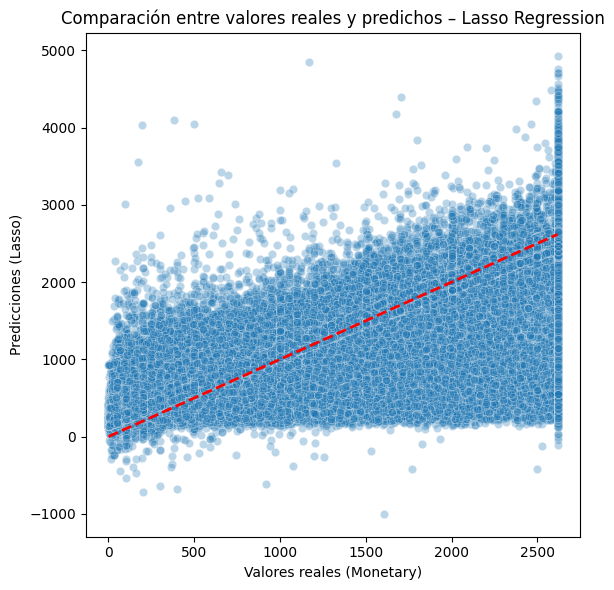

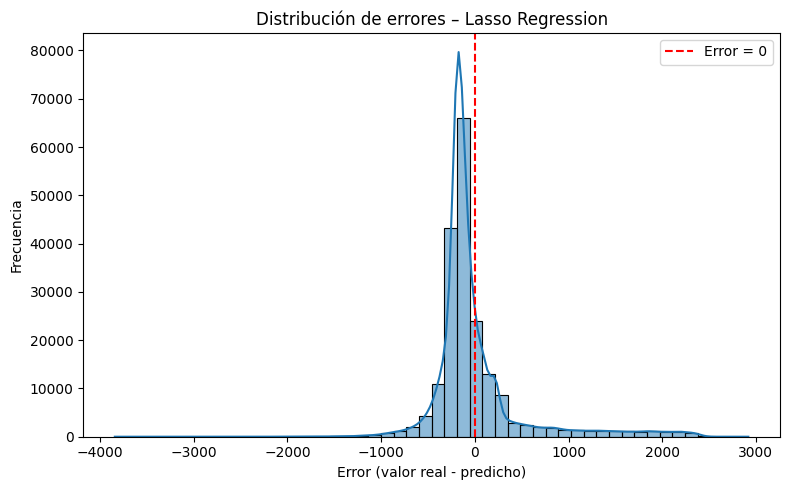

In [4]:
# =========================================================
# 1️⃣ SCATTERPLOT – Valores reales vs. predichos
# =========================================================
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores reales (Monetary)")
plt.ylabel("Predicciones (Lasso)")
plt.title("Comparación entre valores reales y predichos – Lasso Regression")
plt.tight_layout()
plt.show()

# =========================================================
# 2️⃣ HISTOGRAMA DE ERRORES (Residuos)
# =========================================================
errores = y_test - y_pred

plt.figure(figsize=(8,5))
sns.histplot(errores, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--', label="Error = 0")
plt.xlabel("Error (valor real - predicho)")
plt.ylabel("Frecuencia")
plt.title("Distribución de errores – Lasso Regression")
plt.legend()
plt.tight_layout()
plt.show()

Se puede visualizar que es muy similar a Ridge y Linear, se ve robusto en cuanto a variables